## Pronóstico de series de tiempo de precipitación con autoencoder y DMD

In [ ]:
import pandas as pd
import xarray as xr
import numpy as np
from keras.models import Model
from keras.layers import Input, LSTM, RepeatVector, Dense
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from pydmd import DMD

# Parámetros del espacio latente
#latent_dim = 100 # Ajustar la dimensión del espacio latente

2025-10-08 05:45:21.403663: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-08 05:45:21.460333: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-10-08 05:45:21.460359: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-10-08 05:45:21.460433: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-10-08 05:45:21.480638: I tensorflow/core/platform/cpu_feature_g

In [3]:
# Ruta del archivo (ya debe estar en la carpeta montada)
archivo = "../data/ERA5_daily_precipitation_1950_2022.nc"

# Abrir dataset
ds = xr.open_dataset(archivo)
ds

<xarray.Dataset> Size: 678MB
Dimensions:    (time: 26663, latitude: 155, longitude: 41)
Coordinates:
  * longitude  (longitude) float32 164B -76.0 -75.75 -75.5 ... -66.25 -66.0
  * latitude   (latitude) float32 620B -17.5 -17.75 -18.0 ... -55.5 -55.75 -56.0
  * time       (time) datetime64[ns] 213kB 1950-01-01T12:00:00 ... 2022-12-31...
Data variables:
    tp         (time, latitude, longitude) float32 678MB ...

In [4]:

ds = ds.sel(time=slice("1980-01-01", "2022-12-31")) # Filtra desde 2000 a 2022
ds = ds.sel(latitude=slice(-30, -40)) # Filtra zona central
ds['tp'] = ds['tp'].where(ds['tp'] >= 0, 0) # Hace toda tp>=0
ds

<xarray.Dataset> Size: 106MB
Dimensions:    (time: 15706, latitude: 41, longitude: 41)
Coordinates:
  * longitude  (longitude) float32 164B -76.0 -75.75 -75.5 ... -66.25 -66.0
  * latitude   (latitude) float32 164B -30.0 -30.25 -30.5 ... -39.5 -39.75 -40.0
  * time       (time) datetime64[ns] 126kB 1980-01-01T12:00:00 ... 2022-12-31...
Data variables:
    tp         (time, latitude, longitude) float32 106MB 0.2402 0.2736 ... 0.0

In [5]:
import numpy as np
import xarray as xr
import tensorflow as tf
from numpy.lib.stride_tricks import sliding_window_view

# =========================
# 2) Ordena coords: lon O→E, lat S→N
# =========================
if float(ds.longitude[0]) > float(ds.longitude[-1]):
    ds = ds.sortby("longitude")
# ERA5 suele traer lat N→S; queremos S→N (ascendente)
if float(ds.latitude[0]) > float(ds.latitude[-1]):
    ds = ds.sortby("latitude")

In [6]:
# =========================
# 3) Extrae tensor base (T, H, W, C)
# =========================
tp = ds["tp"]  # mm por paso temporal
# Asegura dtype
tp = tp.astype("float32")

# Manejo de NaNs: relleno + canal máscara (opcional)
use_mask_channel = False
if tp.isnull().any():
    use_mask_channel = True
    mask = xr.where(tp.notnull(), 1.0, 0.0).astype("float32")
    tp = tp.fillna(0.0)

# A (T,H,W)
X = tp.transpose("time", "latitude", "longitude").values  # -> (T,H,W)
T_total, H, W = X.shape

# Apila canales
channels = [X[..., None]]  # C=1
if use_mask_channel:
    M = mask.transpose("time", "latitude", "longitude").values.astype("float32")
    channels.append(M[..., None])  # C+=1
X_full = np.concatenate(channels, axis=-1).astype("float32")  # (T,H,W,C)
C = X_full.shape[-1]

print("Forma maestro:", X_full.shape)  # esperado: (8401, 41, 41, C)

Forma maestro: (15706, 41, 41, 1)


In [7]:
# =========================
# 4) Splits temporales (ajusta fechas a tu rango real)
# =========================
# Usa las fechas del dataset para que no falle si no tienes todo 2000–2022
t0 = np.datetime_as_string(ds.time.values[0], unit="D")
t1 = np.datetime_as_string(ds.time.values[-1], unit="D")
print("Rango temporal:", t0, "→", t1)

Rango temporal: 1980-01-01 → 2022-12-31


In [8]:
time_train = ["2000-01-01", "2016-12-31"]
time_val = ["2017-01-01", "2019-12-31"]
time_test = ["2020-01-01",None]

def to_array(dsi):
    arr = dsi["tp"].transpose("time", "latitude", "longitude").astype("float32")
    if use_mask_channel:
        m = xr.where(dsi["tp"].notnull(), 1.0, 0.0).transpose("time","latitude","longitude").astype("float32")
        arr = xr.concat([arr, m], dim="channel")  # (time, lat, lon, channel) pero falta expand
        arr = arr.transpose("time","latitude","longitude","channel")
        return arr.values
    else:
        return arr.values[..., None]

Xtr = to_array(ds.sel(time=slice(time_train[0], time_train[1])))
Xva = to_array(ds.sel(time=slice(time_val[0], time_val[1])))
Xte = to_array(ds.sel(time=slice(time_test[0], time_test[1])))

print("Train:", Xtr.shape, "Val:", Xva.shape, "Test:", Xte.shape)

Train: (6210, 41, 41, 1) Val: (1095, 41, 41, 1) Test: (1096, 41, 41, 1)


In [9]:
# =========================
# 5) Normalización (solo con TRAIN)
#    z-score por canal; para precip muy sesgada podrías hacer log1p antes
# =========================
# Si quieres log1p solo en canal 0 (tp), descomenta:
# Xtr[...,0] = np.log1p(Xtr[...,0])
# Xva[...,0] = np.log1p(Xva[...,0])
# Xte[...,0] = np.log1p(Xte[...,0])

# Stats por canal usando train (media/σ sobre (time, lat, lon))
mu = Xtr.reshape(-1, C).mean(axis=0)
sd = Xtr.reshape(-1, C).std(axis=0) + 1e-8

def normalize(x, mu, sd):
    return (x - mu.reshape(1,1,1,C)) / sd.reshape(1,1,1,C)

Xtr = normalize(Xtr, mu, sd).astype("float32")
Xva = normalize(Xva, mu, sd).astype("float32")
Xte = normalize(Xte, mu, sd).astype("float32")

# =========================
# 6) Ventaneo temporal (N, T, H, W, C)
# =========================
T_window = 32   # longitud de ventana
stride   = 1    # salto entre ventanas


def make_windows(X4d, T=32, S=4):
    """
    X4d: (T_total, H, W, C)  ->  (N, T, H, W, C)
    Ventaneo solo en tiempo, con stride S.
    """
    tlen = X4d.shape[0]
    if tlen < T:
        return np.empty((0, T) + X4d.shape[1:], dtype=X4d.dtype)
    starts = np.arange(0, tlen - T + 1, S, dtype=int)
    out = np.empty((len(starts), T) + X4d.shape[1:], dtype=X4d.dtype)
    for j, i in enumerate(starts):
        out[j] = X4d[i:i+T]   # (T, H, W, C)
    return out

Xtr_w = make_windows(Xtr, T_window, stride)
Xva_w = make_windows(Xva, T_window, stride)
Xte_w = make_windows(Xte, T_window, stride)

print("Windows → Train:", Xtr_w.shape, "Val:", Xva_w.shape, "Test:", Xte_w.shape)
# Ejemplo esperado con T_total~8401: (≈2093, 32, 41, 41, C)

Windows → Train: (6179, 32, 41, 41, 1) Val: (1064, 32, 41, 41, 1) Test: (1065, 32, 41, 41, 1)


In [10]:
# =========================
# 7) tf.data Datasets
# =========================
batch_size = 16
AUTOTUNE = tf.data.AUTOTUNE

def to_ds(X):
    ds = tf.data.Dataset.from_tensor_slices((X, X))  # AE: input = target
    #ds = ds.shuffle(min(len(X), 4096), reshuffle_each_iteration=True, seed=42)
    ds = ds.batch(batch_size).prefetch(AUTOTUNE)
    return ds

train_ds = to_ds(Xtr_w)
val_ds   = tf.data.Dataset.from_tensor_slices((Xva_w, Xva_w)).batch(batch_size).prefetch(AUTOTUNE)
test_ds  = tf.data.Dataset.from_tensor_slices((Xte_w, Xte_w)).batch(batch_size)

2025-10-08 05:45:30.066745: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-10-08 05:45:30.076604: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-10-08 05:45:30.076642: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-10-08 05:45:30.079165: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-10-08 05:45:30.079209: I tensorflow/compile

In [11]:
# === antes de construir el modelo ===
H, W = 41, 41          # tus dims actuales
t_factor = 2*2*2       # por si cambias strides en tiempo (aquí 8)
sp_factor = 2*2*2*2    # factor espacial total (aquí 16)

def pad_to_multiple(n, k):
    need = (-n) % k               # cuánto falta para múltiplo de k
    return need // 2, need - need // 2  # reparto (arriba/abajo)

pad_h = pad_to_multiple(H, sp_factor)   # (3,4) para 41→48
pad_w = pad_to_multiple(W, sp_factor)   # (3,4) para 41→48
print("padding H,W:", pad_h, pad_w)

padding H,W: (3, 4) (3, 4)


In [12]:
from tensorflow.keras import layers, Model

input_shape = (T_window, H, W, C)
inp = layers.Input(shape=input_shape)

# PAD al inicio → (T, 48, 48, C)
x = layers.ZeroPadding3D(padding=((0,0), pad_h, pad_w))(inp)

# Encoder
x = layers.Conv3D(16, (3,3,3), strides=(1,1,1), padding="same", activation="relu")(x)
#x = layers.Conv3D(32, (3,3,3), strides=(2,2,2), padding="same", activation="relu")(x)
#x = layers.Conv3D(64, (3,3,3), strides=(2,2,2), padding="same", activation="relu")(x)

z = layers.Conv3D(32, (3,3,3), strides=(2,2,2), padding="same", activation="relu", name="Latent_Space")(x)

# Decoder (espejo)
#x = layers.Conv3DTranspose(64, (3,3,3), strides=(2,2,2), padding="same", activation="relu")(z)
#x = layers.Conv3DTranspose(32, (3,3,3), strides=(2,2,2), padding="same", activation="relu")(z)#(x)
x = layers.Conv3DTranspose(16, (3,3,3), strides=(2,2,2), padding="same", activation="relu")(z)#(x)
x = layers.Conv3DTranspose(C,  (3,3,3), strides=(1,1,1), padding="same", activation="linear")(x)

# CROP al final → (T, 41, 41, C) exactamente como tu target
out = layers.Cropping3D(cropping=((0,0), pad_h, pad_w))(x)

# --- Pinball ---
def pinball_loss(tau=0.98):
    tau = tf.constant(tau, dtype=tf.float32)
    def loss_fn(y_true, y_pred):
        e = y_true - y_pred
        return tf.reduce_mean(tf.maximum(tau*e, (tau-1.0)*e))
    return loss_fn


#def pinball_huber_loss(tau=0.98, delta=1.0):
def pinball_loss(tau=0.98, delta=5.0):

    """
    Pinball suavizado con Huber.
    tau   : cuantil objetivo (0<tau<1)
    delta : ancho de la zona cuadrática (misma unidad que y_true)
    """
    tau   = tf.constant(tau,  dtype=tf.float32)
    delta = tf.constant(delta, dtype=tf.float32)

    def loss_fn(y_true, y_pred):
        e = y_true - y_pred                # residuo
        a = tf.abs(e)

        # |e|_delta (Huber)
        huber = tf.where(a <= delta, 0.5*tf.square(e)/delta, a - 0.5*delta)

        # asimetría del cuantil (peso según el signo del residuo)
        w = tf.where(e >= 0.0, tau, 1.0 - tau)

        return tf.reduce_mean(w * huber)

    return loss_fn

# --- Mezcla Tweedie + MSE + Pinball ---
def mixed_mse_pinball(
    w_mse=0.50, w_pin=0.50,
    tau=0.98):
    pin = pinball_loss(tau)

    def loss_fn(y_true, y_pred):
        y_true_mm = y_true
        y_pred_mm = y_pred

        # Componentes
        mse = tf.reduce_mean(tf.square(y_true - y_pred))
        pbl = pin(y_true_mm, y_pred_mm)

        return w_mse*mse + w_pin*pbl

    return loss_fn

w_mse= 0.15
w_pin= 0.85
tau_ = 0.99

ae = Model(inp, out)
#ae.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss=mixed_mse_pinball(w_mse=w_mse, w_pin=w_pin, tau=tau_), metrics=[pinball_loss(tau_), 'mse', tf.keras.metrics.RootMeanSquaredError(name='rmse')])
ae.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')])
ae.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 41, 41, 1)]   0         
                                                                 
 zero_padding3d (ZeroPaddin  (None, 32, 48, 48, 1)     0         
 g3D)                                                            
                                                                 
 conv3d (Conv3D)             (None, 32, 48, 48, 16)    448       
                                                                 
 Latent_Space (Conv3D)       (None, 16, 24, 24, 32)    13856     
                                                                 
 conv3d_transpose (Conv3DTr  (None, 32, 48, 48, 16)    13840     
 anspose)                                                        
                                                                 
 conv3d_transpose_1 (Conv3D  (None, 32, 48, 48, 1)     433   

In [13]:
# =========================
# 9) Entrenamiento
# =========================
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model

version_ae = "v1.2"

np.savez(
    f"../models/normalizacion_tp_{version_ae}.npz",
    mu=mu, sd=sd,
    w_mse=w_mse, w_pin=w_pin, tau_=tau_,
    T_window=T_window, stride=stride,
    use_mask_channel=np.array([use_mask_channel], dtype=np.int8)
)

early = EarlyStopping(
    monitor='val_loss',
    patience=12,
    restore_best_weights=True
)

epochs = 100
history = ae.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=[early])

ae.save(f"../models/ae_3d_era5_tp_{version_ae}.keras")

Epoch 1/100


2025-10-08 04:09:30.283102: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8600
2025-10-08 04:09:31.220405: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fa78c3825c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-10-08 04:09:31.220439: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Laptop GPU, Compute Capability 8.9
2025-10-08 04:09:31.223844: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-10-08 04:09:31.293368: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


387/387 [==============================] - 14s 32ms/step - loss: 0.0641 - rmse: 0.2533 - val_loss: 0.0102 - val_rmse: 0.1008
Epoch 2/100
387/387 [==============================] - 14s 37ms/step - loss: 0.0189 - rmse: 0.1376 - val_loss: 0.0073 - val_rmse: 0.0857
Epoch 3/100
387/387 [==============================] - 11s 30ms/step - loss: 0.0069 - rmse: 0.0832 - val_loss: 0.0046 - val_rmse: 0.0678
Epoch 4/100
387/387 [==============================] - 14s 37ms/step - loss: 0.0063 - rmse: 0.0794 - val_loss: 0.0034 - val_rmse: 0.0583
Epoch 5/100
387/387 [==============================] - 12s 30ms/step - loss: 0.0042 - rmse: 0.0646 - val_loss: 0.0027 - val_rmse: 0.0516
Epoch 6/100
387/387 [==============================] - 12s 30ms/step - loss: 0.0042 - rmse: 0.0645 - val_loss: 0.0021 - val_rmse: 0.0461
Epoch 7/100
387/387 [==============================] - 14s 37ms/step - loss: 0.0029 - rmse: 0.0543 - val_loss: 0.0019 - val_rmse: 0.0437
Epoch 8/100
387/387 [==============================] 

In [12]:
from tensorflow.keras.models import load_model

version_ae = "v1.2"
ae = load_model(f"../models/ae_3d_era5_tp_{version_ae}.keras")

In [ ]:
def plot_training_metrics(history):
    fig, axes = plt.subplots(3, 1, figsize=(15, 10), sharex=True)
    
    # ---- LOSS ----
    ax = axes[0]
    if 'loss' in history.history:
        ax.plot(history.history['loss'], label='Entrenamiento', linewidth=2)
    if 'val_loss' in history.history:
        ax.plot(history.history['val_loss'], label='Validación', linewidth=2, linestyle='--')
    ax.set_title('Pérdida (Loss)')
    ax.set_ylabel('Loss')
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.5)
    
    # ---- SMAPE ----
    ax = axes[1]
    if 'mse' in history.history:
        ax.plot(history.history['mse'], label='Entrenamiento', linewidth=2)
    if 'val_mse' in history.history:
        ax.plot(history.history['val_mse'], label='Validación', linewidth=2, linestyle='--')
    ax.set_title('Error Cuadrático Medio (MSE)')
    ax.set_ylabel('MSE')
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.5)
    
    # ---- RMSE ----
    ax = axes[2]
    if 'rmse' in history.history:
        ax.plot(history.history['rmse'], label='Entrenamiento', linewidth=2)
    if 'val_rmse' in history.history:
        ax.plot(history.history['val_rmse'], label='Validación', linewidth=2, linestyle='--')
    ax.set_title('Raíz del Error Cuadrático Medio (RMSE)')
    ax.set_xlabel('Épocas')
    ax.set_ylabel('RMSE')
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()


plot_training_metrics(history)

NameError: name 'history' is not defined

In [13]:
# =========================
# 10) Eval & ejemplo de uso
# =========================
test_loss = ae.evaluate(test_ds)
print("Test loss:", test_loss)

2025-10-08 05:45:35.383074: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8600


67/67 [==============================] - 3s 18ms/step - loss: 8.9901e-06 - rmse: 0.0030
Test loss: [8.99009046406718e-06, 0.002998348092660308]


In [14]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
recons = ae.predict(val_ds, batch_size=8)

# Flatten por ventana para evaluar MSE/MAE promedio
mse = np.mean((recons - Xva_w)**2)
mae = np.mean(np.abs(recons - Xva_w))
smape = np.mean(np.abs(2 * (recons - Xva_w) / (recons + Xva_w + np.finfo(float).eps)))

print(f"Validacion:")
print(f"MSE total  : {mse:.6f}")
print(f"MAE total  : {mae:.6f}")
print(f"SMAPE total: {smape*100:.3f} %")

67/67 [==============================] - 1s 21ms/step
Validacion:
MSE total  : 0.000011
MAE total  : 0.001501
SMAPE total: 1.950 %


In [15]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
recons = ae.predict(test_ds, batch_size=8)

# Flatten por ventana para evaluar MSE/MAE promedio
mse = np.mean((recons - Xte_w)**2)
mae = np.mean(np.abs(recons - Xte_w))
smape = np.mean(np.abs(2 * (recons - Xte_w) / (recons + Xte_w + np.finfo(float).eps)))

print(f"Test:")
print(f"MSE total  : {mse:.6f}")
print(f"MAE total  : {mae:.6f}")
print(f"SMAPE total: {smape*100:.3f} %")

67/67 [==============================] - 1s 22ms/step
Test:
MSE total  : 0.000009
MAE total  : 0.001361
SMAPE total: 1.499 %


In [16]:
def compare_plots_error(recons, Xte_w, d_time):
    # --- Promedios temporales globales ---
    orig_mean = np.mean(Xte_w[..., 0], axis=(0, 1))
    recon_mean = np.mean(recons[..., 0], axis=(0, 1))
    diff_mean = orig_mean - recon_mean

    fig, ax = plt.subplots(1, 3, figsize=(14, 4))
    im0 = ax[0].imshow(orig_mean, cmap='viridis')
    ax[0].set_title('Original promedio')
    plt.colorbar(im0, ax=ax[0], fraction=0.046, pad=0.04)

    im1 = ax[1].imshow(recon_mean, cmap='viridis')
    ax[1].set_title('Reconstruido promedio')
    plt.colorbar(im1, ax=ax[1], fraction=0.046, pad=0.04)

    im2 = ax[2].imshow(diff_mean, cmap='RdBu', vmin=-np.max(abs(diff_mean)), vmax=np.max(abs(diff_mean)))
    ax[2].set_title('Diferencia (Original - Reconstruido)')
    plt.colorbar(im2, ax=ax[2], fraction=0.046, pad=0.04)

    for a in ax: a.axis('off')
    plt.tight_layout()
    plt.show()

    # --- Errores espaciales promedio ---
    rmse_map = np.sqrt(np.mean((recons - Xte_w)**2, axis=(0, 1, 4)))   # (H, W)
    mae_map  = np.mean(np.abs(recons - Xte_w), axis=(0, 1, 4))         # (H, W)

    fig, ax = plt.subplots(1, 2, figsize=(11, 4))
    im0 = ax[0].imshow(rmse_map, cmap='inferno')
    ax[0].set_title('Error RMSE promedio por píxel')
    plt.colorbar(im0, ax=ax[0], fraction=0.046, pad=0.04)

    im1 = ax[1].imshow(mae_map, cmap='inferno')
    ax[1].set_title('Error MAE promedio por píxel')
    plt.colorbar(im1, ax=ax[1], fraction=0.046, pad=0.04)

    for a in ax: a.axis('off')
    plt.tight_layout()
    plt.show()

    # --- Errores temporales promedio (por ventana) ---
    rmse_time = np.sqrt(np.mean((recons - Xte_w)**2, axis=(2, 3, 4)))  # (N, T)
    mae_time  = np.mean(np.abs(recons - Xte_w), axis=(2, 3, 4))        # (N, T)
    rmse_per_window = rmse_time.mean(axis=1)
    mae_per_window  = mae_time.mean(axis=1)

    # --- Energía media del campo original y reconstruido ---
    orig_energy  = np.mean(Xte_w[..., 0], axis=(2, 3)).mean(axis=1)
    recon_energy = np.mean(recons[..., 0], axis=(2, 3)).mean(axis=1)

    # === Evolución temporal (1): comparación original vs reconstruido ===
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.plot(d_time, orig_energy, label='Original (energía media)', alpha=0.8)
    ax.plot(d_time, recon_energy, label='Reconstruido (energía media)', linestyle='--', alpha=0.9)
    ax.set_title('Evolución temporal: Original vs Reconstrucción')
    ax.set_xlabel('Ventana temporal (orden cronológico)')
    ax.set_ylabel('Valor medio del campo')
    ax.grid(alpha=0.3)
    ax.legend(loc='best')
    plt.tight_layout()
    plt.show()

    # === Evolución temporal (2): errores RMSE y MAE juntos ===
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.plot(d_time, rmse_per_window, label='RMSE', color='tab:red', alpha=0.9)
    ax.plot(d_time, mae_per_window, label='MAE', color='tab:blue', alpha=0.9)
    ax.set_title('Evolución temporal de errores (RMSE y MAE)')
    ax.set_xlabel('Ventana temporal (orden cronológico)')
    ax.set_ylabel('Error')
    ax.grid(alpha=0.3)
    ax.legend(loc='best')
    plt.tight_layout()
    plt.show()

    # --- Distribución global de errores ---
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    ax[0].hist(rmse_per_window, bins=40, color='tab:red', alpha=0.7)
    ax[0].set_title('Distribución de errores RMSE por ventana')
    ax[0].set_xlabel('RMSE'); ax[0].set_ylabel('Frecuencia')

    ax[1].hist(mae_per_window, bins=40, color='tab:blue', alpha=0.7)
    ax[1].set_title('Distribución de errores MAE por ventana')
    ax[1].set_xlabel('MAE'); ax[1].set_ylabel('Frecuencia')

    plt.tight_layout()
    plt.show()


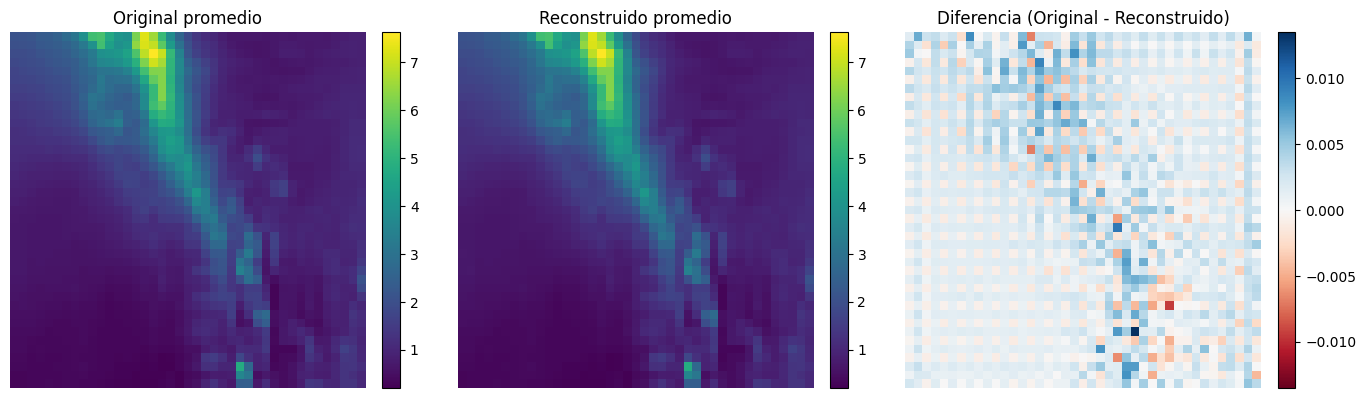

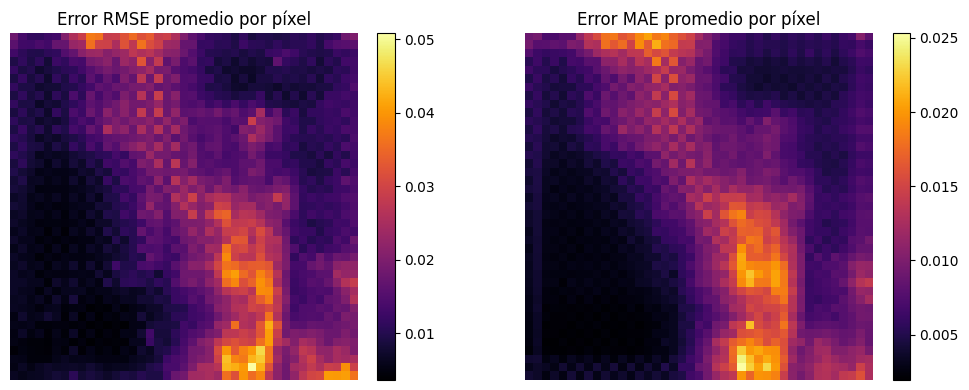

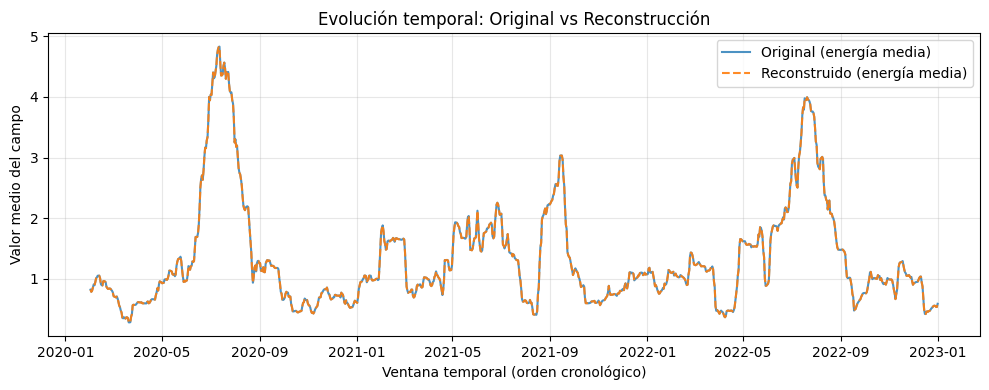

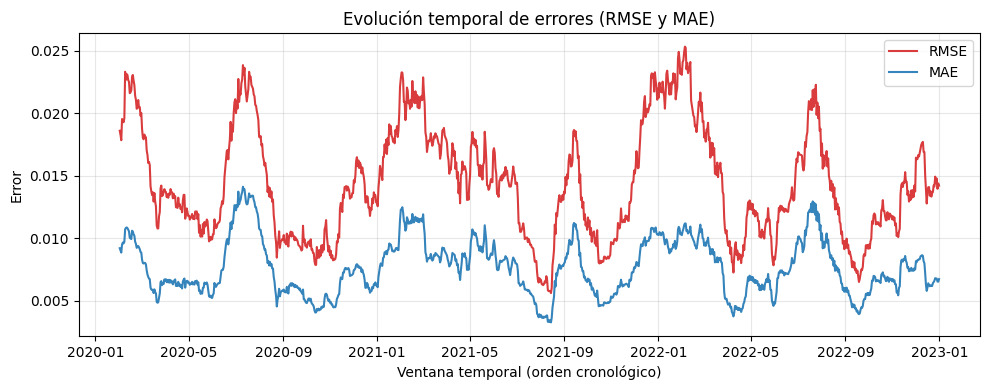

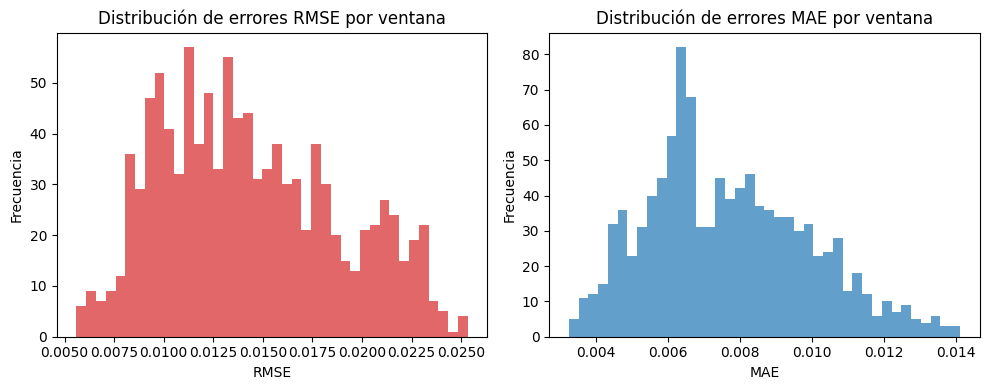

In [17]:
compare_plots_error(recons*sd + mu, Xte_w*sd + mu, ds['time'].values[-Xte_w.shape[0]:])

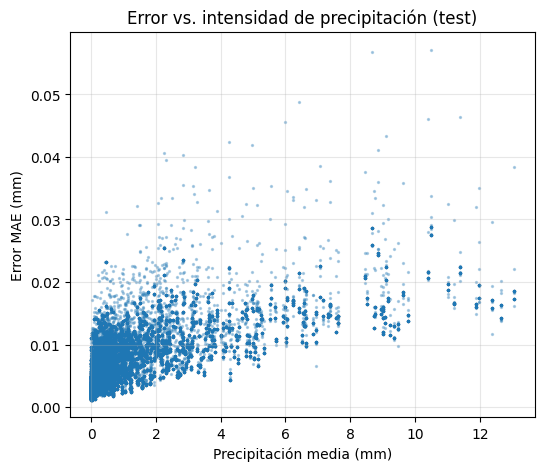

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Valor medio vs error (por frame)
orig_vals = np.mean(Xte_w[..., 0]*sd + mu, axis=(2, 3))   # (N, T)
err_vals  = np.mean(np.abs(recons*sd - Xte_w*sd), axis=(2, 3, 4)) # (N, T)

plt.figure(figsize=(6,5))
plt.scatter(orig_vals.flatten(), err_vals.flatten(), s=2, alpha=0.3)
plt.xlabel("Precipitación media (mm)")
plt.ylabel("Error MAE (mm)")
plt.title("Error vs. intensidad de precipitación (test)")
plt.grid(alpha=0.3)
plt.show()

<Figure size 2000x800 with 0 Axes>

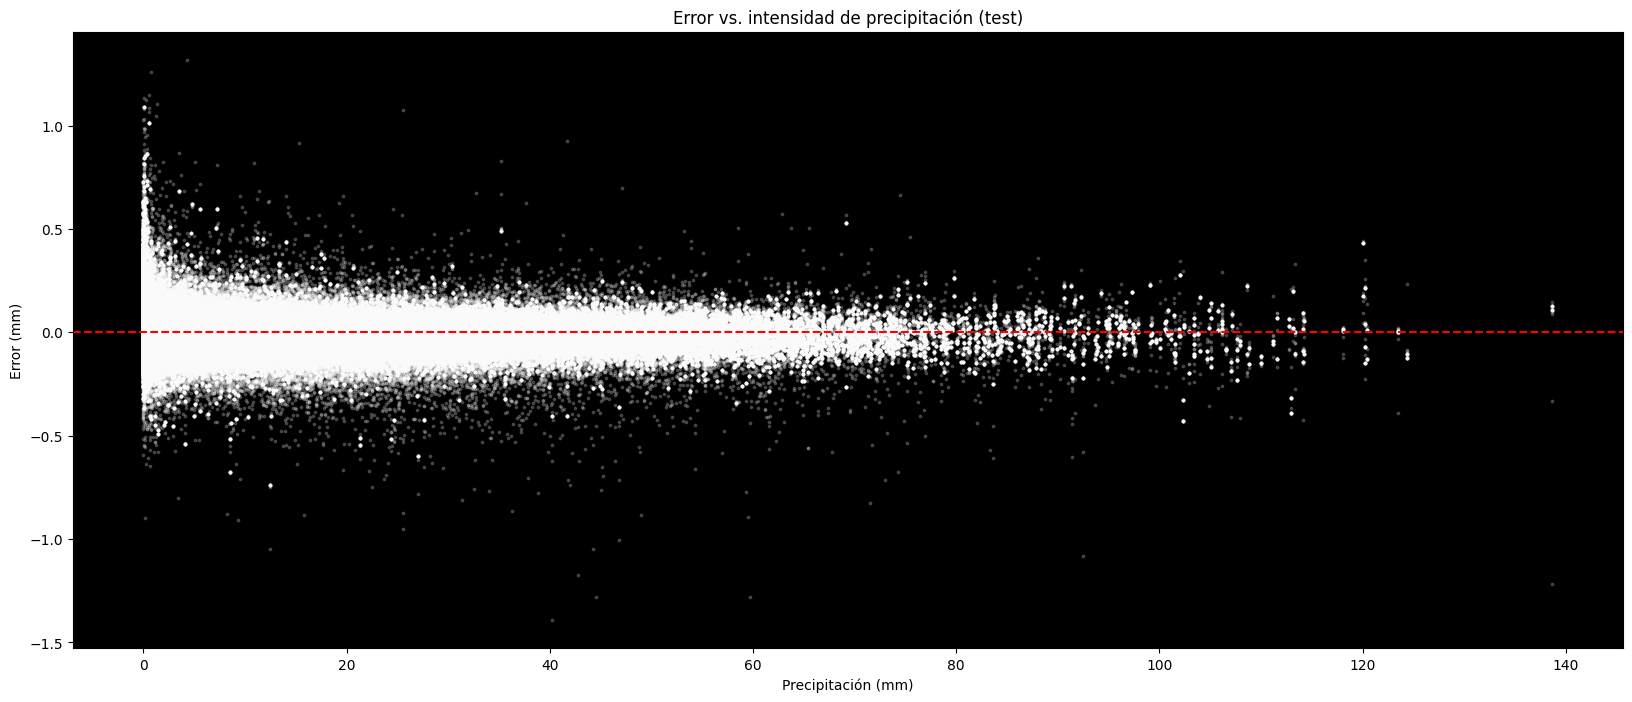

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Valor medio vs error (por frame)
orig_vals = (Xte_w[..., 0].reshape(-1))*sd + mu
err_vals  = (recons*sd - Xte_w*sd).reshape(-1)

plt.figure(figsize=(20,8))
fig, ax = plt.subplots(figsize=(20,8))

ax.axhline(y=0, color='r', linestyle="--")
ax.scatter(orig_vals, err_vals, s=3, alpha=0.2, color='white')
ax.set_facecolor('black')
ax.set_xlabel("Precipitación (mm)")
ax.set_ylabel("Error (mm)")
ax.set_title("Error vs. intensidad de precipitación (test)")
plt.show()

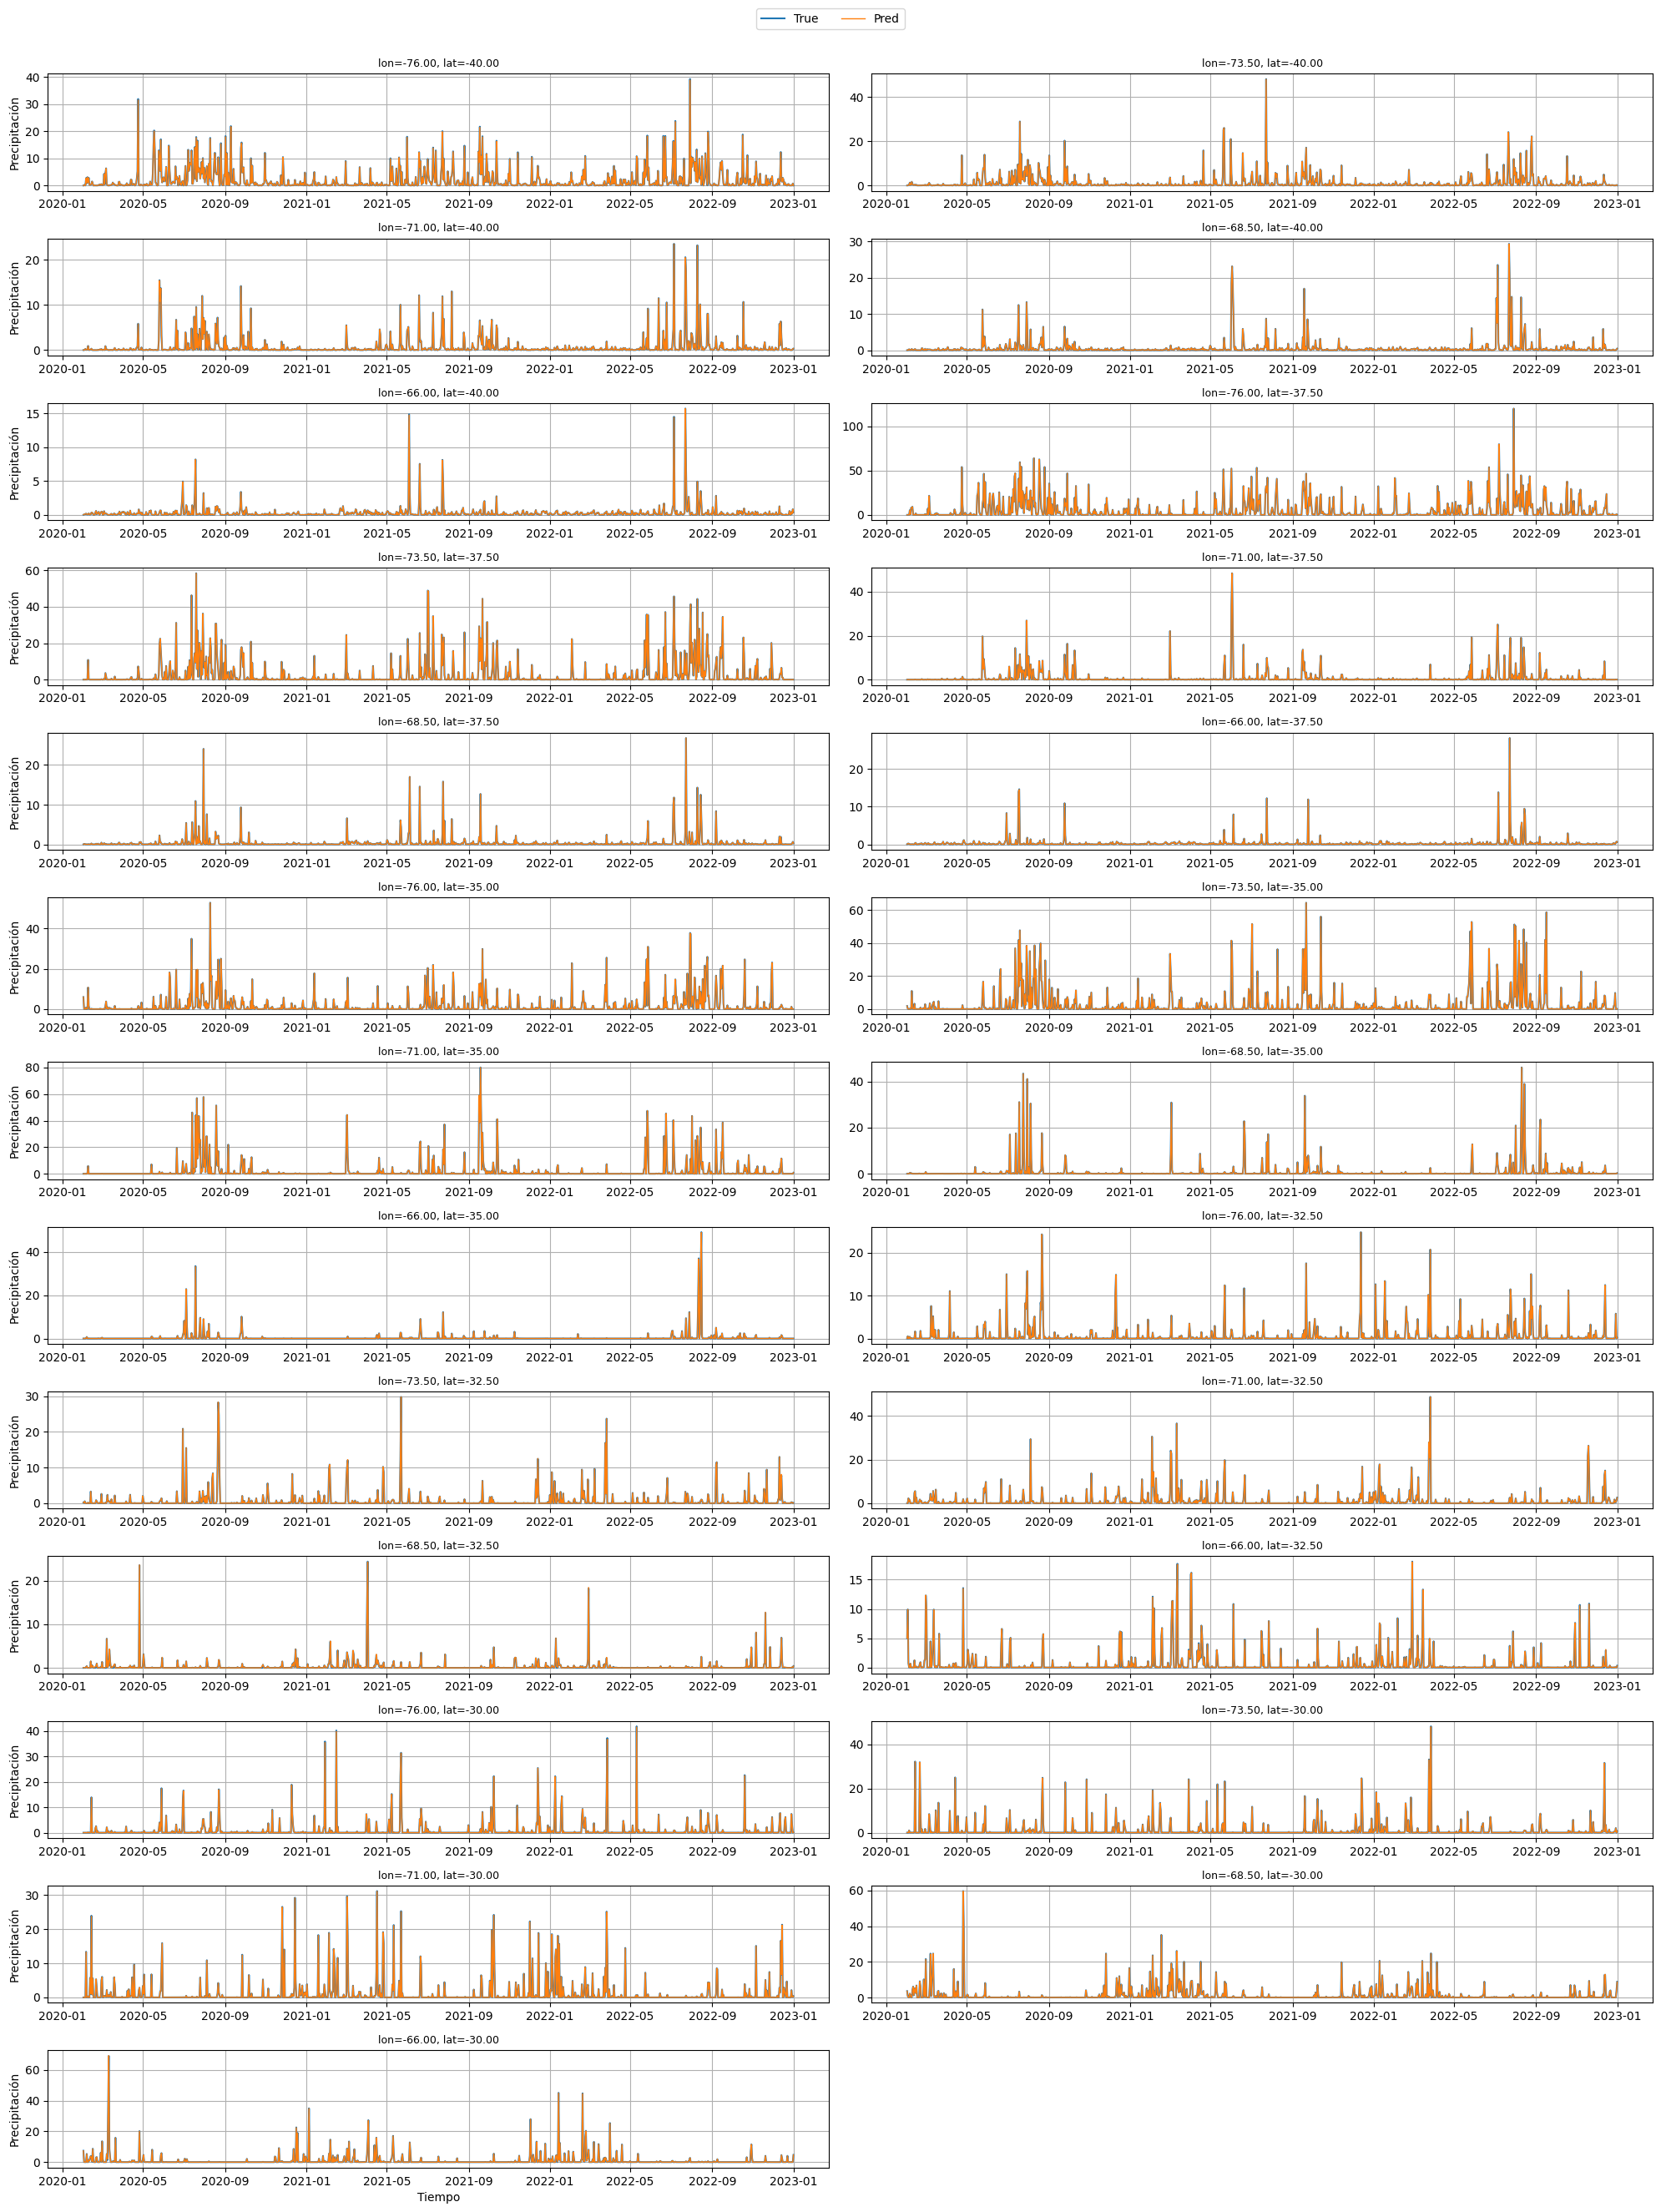

In [20]:
import math

# --- Configuración ---
coords = [(0, 0), (10, 0), (20, 0), (30, 0), (40, 0),
          (0, 10), (10, 10), (20, 10), (30, 10), (40, 10),
          (0, 20), (10, 20), (20, 20), (30, 20), (40, 20),
          (0, 30), (10, 30), (20, 30), (30, 30), (40, 30),
          (0, 40), (10, 40), (20, 40), (30, 40), (40, 40)]
n = 13   # número de filas
m = 2   # número de columnas
assert n*m >= len(coords), "La rejilla debe tener al menos tantos subplots como coordenadas"

# --- Crear figura y ejes ---
fig, axes = plt.subplots(n, m, figsize=(20, n*2), sharex=False, sharey=False)
axes = axes.ravel()

# --- Graficar ---
for i, (lo, la) in enumerate(coords):
    ax = axes[i]
    ax.plot(ds['time'].values[-Xte_w.shape[0]:], (Xte_w*sd + mu)[:, 0, lo, la].reshape(-1), label='True', lw=1.5)
    ax.plot(ds['time'].values[-Xte_w.shape[0]:], (recons*sd + mu)[:, 0, lo, la].reshape(-1), label='Pred', lw=1)
    ax.set_title(f"lon={ds['longitude'].values[lo]:.2f}, lat={ds['latitude'].values[la]:.2f}", fontsize=9)
    ax.grid(True)
    if i % m == 0:
        ax.set_ylabel('Precipitación')
    if i >= (n-1)*m:
        ax.set_xlabel('Tiempo')

# --- Ocultar los subplots vacíos si sobran ---
for j in range(len(coords), n*m):
    axes[j].axis('off')

# --- Ajustes finales ---
fig.legend(['True', 'Pred'], loc='upper center', ncol=2, bbox_to_anchor=(0.5, 1.02))
plt.tight_layout()
plt.show()
